In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import math
import pandas as pd
from lc_lmfit import *

In [2]:
folder='Paper_I/'
filename='_LC_log.txt'
FXRTs=['FXRT_1','FXRT_2','FXRT_3','FXRT_4','FXRT_5','FXRT_6','FXRT_7',
      'FXRT_8','FXRT_9','FXRT_10','FXRT_11','FXRT_12','FXRT_13','FXRT_14']

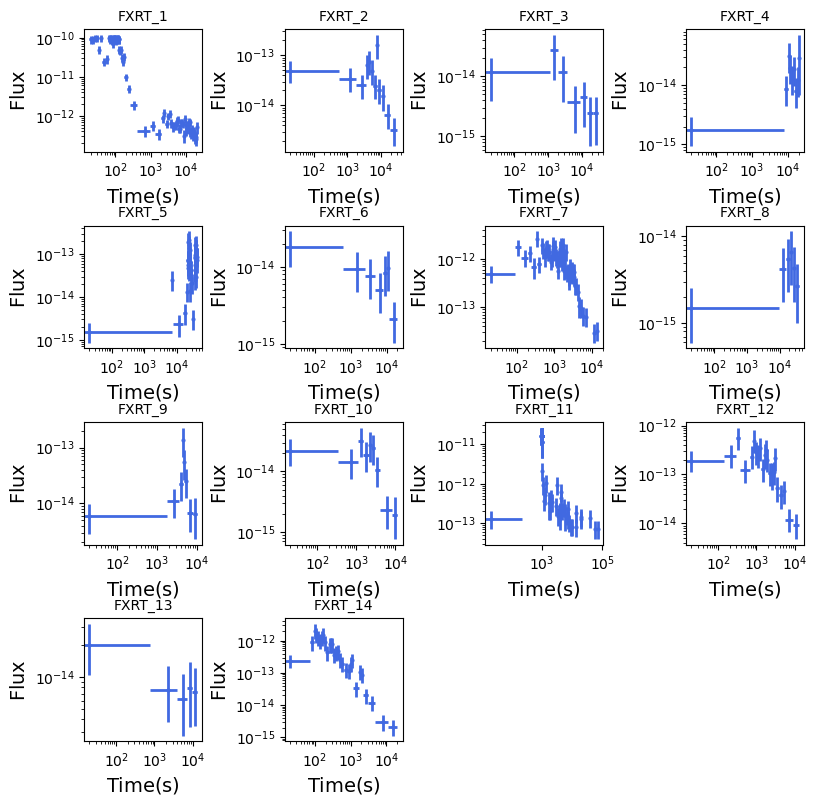

<Figure size 640x480 with 0 Axes>

In [3]:
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(FXRTs)):
    ax1 = fig.add_subplot(4, 4, i+1)
    Time,Flux,Time_low,Time_high,Flux_low,Flux_high=np.loadtxt(folder+FXRTs[i]+filename, unpack=True)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title(FXRTs[i],fontsize=10)


plt.show()
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.9)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 12
    # variables        = 4
    chi-square         = 1.30793907
    reduced chi-square = 0.16349238
    Akaike info crit   = -18.5974478
    Bayesian info crit = -16.6578212
[[Variables]]
    t_break:    5887.51228 +/- 1567.86399 (26.63%) (init = 5900)
    alpha_1:    0.04016014 +/- 0.09653536 (240.38%) (init = 0.04)
    alpha_2:    1.65092177 +/- 0.42276611 (25.61%) (init = 1.7)
    amplitude:  3.5683e-14 +/- 9.3916e-15 (26.32%) (init = 3.6e-14)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = -0.6768
    C(t_break, alpha_2)   = +0.6472
    C(t_break, amplitude) = -0.6241
    C(t_break, alpha_1)   = +0.4052


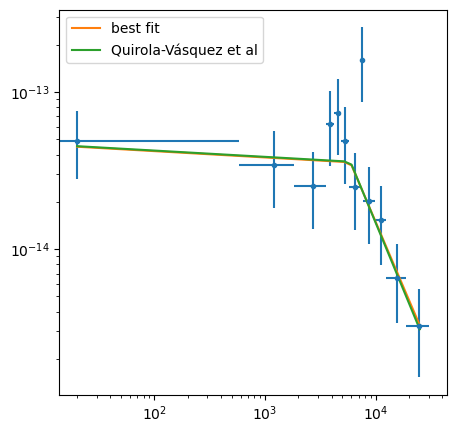

In [4]:
i=1
time,flux,time_low,time_high,flux_low,flux_high=np.loadtxt(folder+FXRTs[i]+filename, unpack=True)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
params=lm.Parameters()
params.add("t_break", min = 1e2, max = 1e5, value = 5.9e3)
params.add("alpha_1", min = 0, max = 1.0, value = 0.04)
params.add("alpha_2", min = 1, max = 2.0, value = 1.7)
params.add("amplitude", min = 1e-16, max = 1e-12, value = 3.6e-14)

minner = lm.Minimizer(cost_func_bpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
tb = bfit["t_break"].value
alp1 = bfit["alpha_1"].value
alp2 = bfit["alpha_2"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)

x1=np.geomspace(20,25000,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,broken_power_law(x1,tb, alp1, alp2, amp),label ='best fit')
plt.plot(x1,broken_power_law(x1,5.9e3,0.04,1.7,3.6e-14),label ='Quirola-Vásquez et al')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

You must install the tqdm library to use progress indicators with emcee


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [239.36292587 125.76740705 108.77731052 206.75789513]


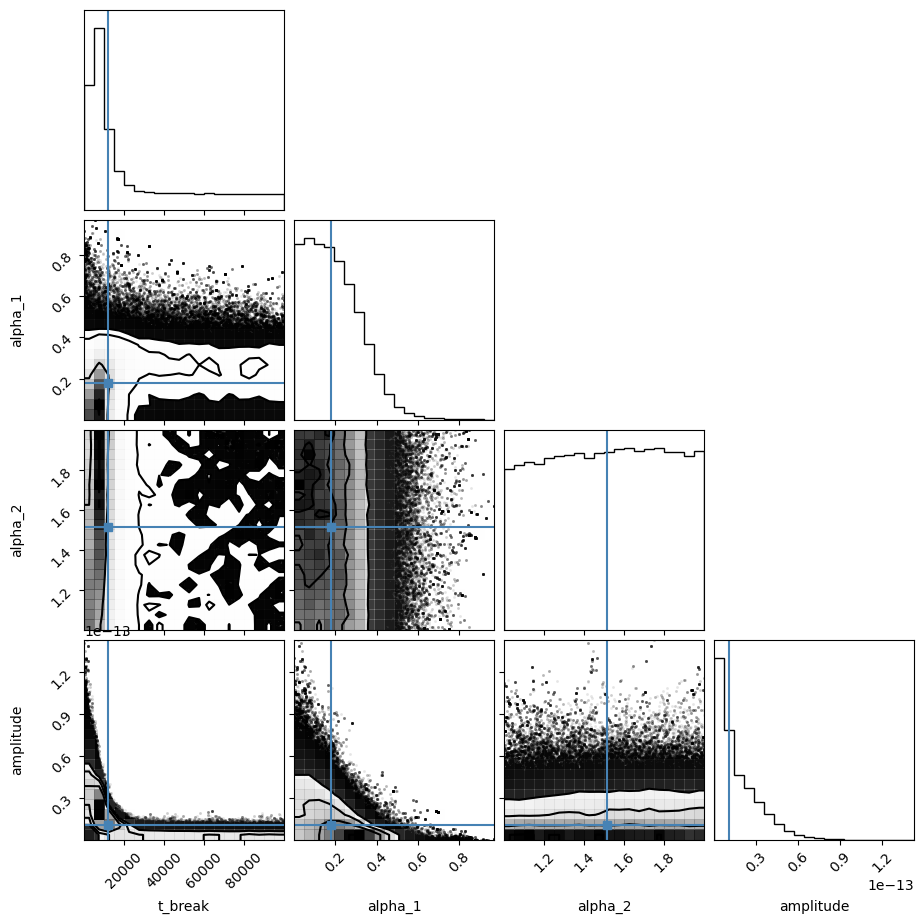

In [5]:
res_refined = lm.minimize(cost_func_bpl, method='emcee', burn=1000, steps=10000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)

emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 46
    # data points      = 7
    # variables        = 4
    chi-square         = 0.20728201
    reduced chi-square = 0.06909400
    Akaike info crit   = -16.6370964
    Bayesian info crit = -16.8534558
[[Variables]]
    t_break:    1259.52314 +/- 1.3128e+10 (1042310489.70%) (init = 1500)
    alpha_1:   -0.14239497 +/- 2432751.37 (1708453209.94%) (init = -0.1)
    alpha_2:    0.82452378 +/- 0.21346016 (25.89%) (init = 0.8)
    amplitude:  2.0941e-14 +/- 1.7997e-07 (859409781.52%) (init = 1.9e-14)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = -1.0000
    C(t_break, amplitude) = -1.0000
    C(t_break, alpha_1)   = +1.0000
    C(t_break, alpha_2)   = +0.1726
    C(alpha_1, alpha_2)   = +0.1726
    C(alpha_2, amplitude) = -0.1726


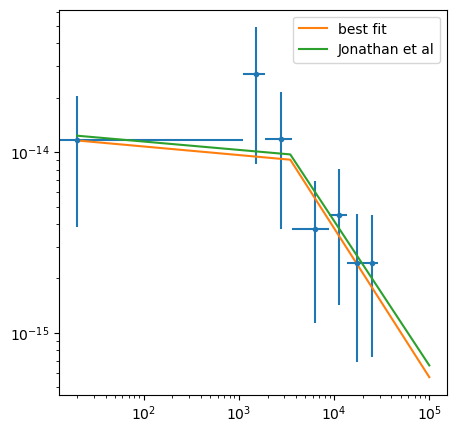

In [6]:
i=2
time,flux,time_low,time_high,flux_low,flux_high=np.loadtxt(folder+FXRTs[i]+filename, unpack=True)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
params=lm.Parameters()
params.add("t_break", min = 1e2, max = 1e5, value = 1.5e3)
params.add("alpha_1", min = -5.0, max = 5.0, value = -0.1)
params.add("alpha_2", min = 0, max = 9.0, value = 0.8)
params.add("amplitude", min = 1e-16, max = 1e-12, value = 1.9e-14)

minner = lm.Minimizer(cost_func_bpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
tb = bfit["t_break"].value
alp1 = bfit["alpha_1"].value
alp2 = bfit["alpha_2"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)

x1=np.geomspace(20,1e5,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,broken_power_law(x1,tb, alp1, alp2, amp),label ='best fit')
plt.plot(x1,broken_power_law(x1,1.5e3,-0.1,0.8,1.9e-14),label ='Jonathan et al')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

100%|██████████| 100000/100000 [04:22<00:00, 380.45it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [2093.44843806  522.11757928  186.13343389  281.55491779]


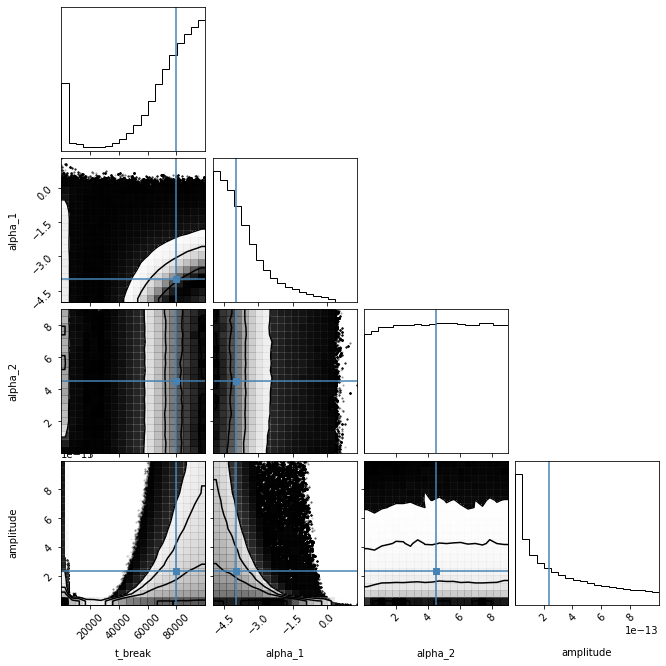

In [ ]:
res_refined = lm.minimize(cost_func_bpl, method='emcee', burn=1000, steps=100000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)

emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))